# 환경설정 및 라이브러리 설치

In [ ]:
# 1. 라이브러리 설치
!pip install pmdarima xgboost

# 2. 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib # 모델 저장용
import json
from google.colab import drive
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

# 3. 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 4. 드라이브 마운트 및 경로 설정
drive.mount('/content/drive')

# 프로젝트 루트 경로 설정 (본인 환경에 맞게 수정 가능)
BASE_PATH = '/content/drive/MyDrive/U-sto_AI'

# 세부 경로 정의
DATA_PATH = os.path.join(BASE_PATH, 'dataset/create_data/data_ml/phase4_training_data.csv')
MODEL_SAVE_DIR = os.path.join(BASE_PATH, 'ai_model/saved_models/hybrid_arima_xgb')
RESULT_DIR = os.path.join(BASE_PATH, 'ai_model/results')
PLOT_DIR = os.path.join(RESULT_DIR, 'plots')

# 폴더가 없으면 생성 (에러 방지)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

print(f"경로 설정 완료")
print(f"📂 데이터 경로: {DATA_PATH}")
print(f"📂 모델 저장 경로: {MODEL_SAVE_DIR}")
print(f"📂 결과 저장 경로: {RESULT_DIR}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

# 나눔 폰트 문제 해결

In [ ]:
# 1. 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum

# 2. matplotlib 폰트 캐시 삭제 (중요)
!rm -rf ~/.cache/matplotlib

# 3. 설치 확인 (아래 문구가 나와야 합니다)
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts()
if any("Nanum" in f for f in fonts):
    print("\n✅ 나눔 폰트 설치 성공! 상단 메뉴 [런타임] -> [런타임 다시 시작] 을 눌러주세요.")
else:
    print("\n❌ 설치 실패. 코드를 다시 실행해주세요.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.

✅ 나눔 폰트 설치 성공! 상단 메뉴 [런타임] -> [런타임 다시 시작] 을 눌러주세요.


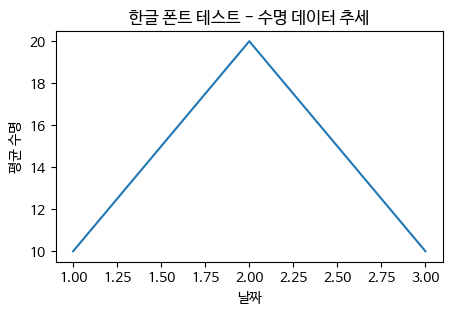

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 테스트 그래프
plt.figure(figsize=(5, 3))
plt.plot([1, 2, 3], [10, 20, 10])
plt.title('한글 폰트 테스트 - 수명 데이터 추세')
plt.xlabel('날짜')
plt.ylabel('평균 수명')
plt.show()

# 데이터 전처리 및 타겟 변수 생성 (Step 1)

[수명 계산 결과 확인]
count     103.000000
mean     1290.067961
std      2129.660699
min        19.000000
25%        38.500000
50%        49.000000
75%      2205.000000
max      7440.000000
Name: Life_Span, dtype: float64

>> 필터링 후 학습 가능한 데이터: 5건
   (평균 수명: 36.6일)

최종 시계열 데이터 생성 완료: 6358일치
데이터 기간: 2006-06-13 ~ 2023-11-08


,y
종료일,
2006-06-13,19.000000
2006-06-14,19.006624
2006-06-15,19.013249
2006-06-16,19.019873
2006-06-17,19.026497


,y
종료일,
2023-11-04,48.975596
2023-11-05,48.981697
2023-11-06,48.987798
2023-11-07,48.993899
2023-11-08,49.000000


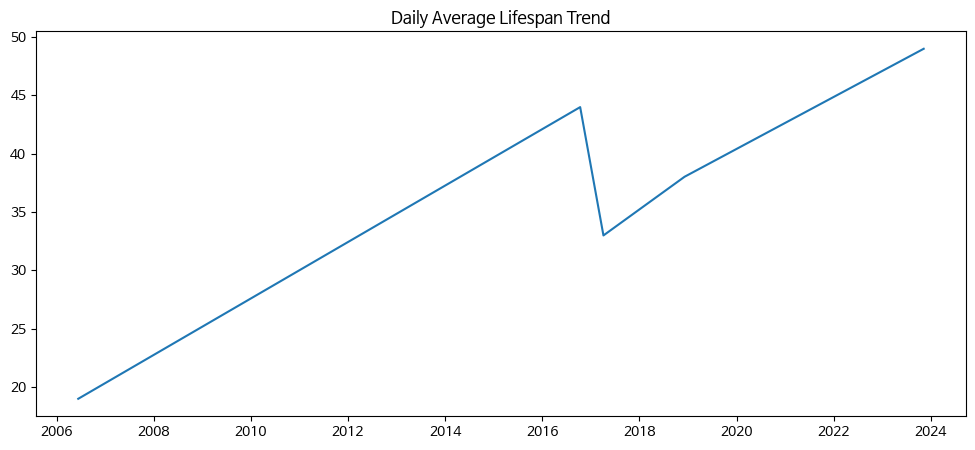

In [ ]:
# 수명 직접 계산 및 시계열 변환
import pandas as pd
import numpy as np
import os

# 1. 데이터 로드
BASE_PATH = '/content/drive/MyDrive/U-sto_AI'
DATA_PATH = os.path.join(BASE_PATH, 'dataset/create_data/data_ml/phase4_training_data.csv')

df = pd.read_csv(DATA_PATH)

# 2. 컬럼 매핑
col_map = {
    '취득일자': '취득일',
    '불용일자': '종료일',
    '처분방식': '처분방식',
    '물품상태': '물품상태'
    # '실제잔여수명' 컬럼은 0이라서 사용하지 않습니다.
}
df.rename(columns=col_map, inplace=True)

# 3. 날짜 변환 (가장 중요!)
df['취득일'] = pd.to_datetime(df['취득일'], errors='coerce')
df['종료일'] = pd.to_datetime(df['종료일'], errors='coerce')

# 4. 수명(Target) 직접 계산: 종료일 - 취득일
# "이 물건은 며칠 동안 쓰였는가?"
df['Life_Span'] = (df['종료일'] - df['취득일']).dt.days

print("[수명 계산 결과 확인]")
print(df['Life_Span'].describe()) # 이제 0이 아닌 숫자가 보여야 합니다.

# 5. 필터링 (PDF 기준)
# 조건: (처분방식 != 매각/도난) AND (물품상태 == 폐품/정비필요품) AND (날짜 정상) AND (수명 > 0)
cond_method = ~df['처분방식'].isin(['매각', '도난'])
cond_status = df['물품상태'].isin(['폐품', '정비필요품'])
cond_date = (df['종료일'].notnull()) & (df['취득일'].notnull())
cond_lifespan = df['Life_Span'] > 0 # 수명이 양수인 것만

df_clean = df[cond_method & cond_status & cond_date & cond_lifespan].copy()

print(f"\n>> 필터링 후 학습 가능한 데이터: {len(df_clean)}건")
print(f"   (평균 수명: {df_clean['Life_Span'].mean():.1f}일)")

# 6. 시계열 변환 (일별 평균 수명 집계)
# 인덱스를 '종료일(처분일)'로 설정
df_clean.set_index('종료일', inplace=True)

# 일 단위(D)로 평균 수명 집계
df_ts = df_clean['Life_Span'].resample('D').mean()

# 빈 날짜 채우기 (Linear Interpolation - 선형 보간이 더 자연스러움)
df_ts = df_ts.interpolate(method='linear')
# 앞뒤 남은 결측치는 ffill/bfill로 처리
df_ts = df_ts.fillna(method='ffill').fillna(method='bfill')

df_ts = df_ts.to_frame()
df_ts.columns = ['y']

print(f"\n최종 시계열 데이터 생성 완료: {len(df_ts)}일치")
print(f"데이터 기간: {df_ts.index.min().date()} ~ {df_ts.index.max().date()}")

# 데이터가 잘 만들어졌는지 눈으로 확인
display(df_ts.head())
display(df_ts.tail())

# 시각화로 확인 (잘 나오는지)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df_ts.index, df_ts['y'])
plt.title("Daily Average Lifespan Trend")
plt.show()

# Base 모델 구축 (ARIMA) (Step 2)

In [ ]:
# 1. Train/Test Split (Time-based split, last 20%)
train_size = int(len(df_ts) * 0.8)
train = df_ts.iloc[:train_size].copy()
test = df_ts.iloc[train_size:].copy()

print(f"학습 기간: {train.index.min().date()} ~ {train.index.max().date()}")
print(f"테스트 기간: {test.index.min().date()} ~ {test.index.max().date()}")

# 2. Auto ARIMA (Trend Prediction)
print("ARIMA 모델 최적화 중...")
model_arima = auto_arima(train['y'],
                         seasonal=True,
                         m=7, # 주간 패턴 고려
                         trace=False,
                         suppress_warnings=True,
                         stepwise=True)

# 3. 예측값 생성 (추세)
train['y_arima'] = model_arima.predict_in_sample()
test['y_arima'] = model_arima.predict(n_periods=len(test))

print(f"ARIMA 학습 완료 (Order: {model_arima.order})")

학습 기간: 2006-06-13 ~ 2020-05-15
테스트 기간: 2020-05-16 ~ 2023-11-08
ARIMA 모델 최적화 중...
ARIMA 학습 완료 (Order: (0, 2, 0))


# 잔차 학습 및 파생변수 생성 (Step 3)

In [ ]:
# 1. 잔차(Residual) 계산
train['resid'] = train['y'] - train['y_arima']
test['resid'] = test['y'] - test['y_arima']

# 2. 파생변수 생성 (Feature Engineering)
def create_features(data):
    df_feat = data.copy()
    # Lag (과거 오차)
    df_feat['lag_1'] = df_feat['resid'].shift(1)
    df_feat['lag_7'] = df_feat['resid'].shift(7)
    # Rolling (이동평균/편차)
    df_feat['rolling_mean_3'] = df_feat['resid'].rolling(3).mean()
    df_feat['rolling_std_7'] = df_feat['resid'].rolling(7).std()
    return df_feat

# 3. NaN 제거 (Shift로 생긴 앞부분 결측 제거)
train_feat = create_features(train).dropna()
test_feat = create_features(test).dropna()

print(f"파생변수 생성 완료 (Train shape: {train_feat.shape})")

파생변수 생성 완료 (Train shape: (5079, 7))


# Correction 모델 (XGBoost) 및 최종 통합 (Step 4 & 5)

In [ ]:
# 1. XGBoost 데이터셋
features = ['lag_1', 'lag_7', 'rolling_mean_3', 'rolling_std_7']
X_train, y_train = train_feat[features], train_feat['resid']
X_test, y_test = test_feat[features], test_feat['resid']

# 2. 모델 학습
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5,
                         random_state=42, early_stopping_rounds=50)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

# 3. 모델 저장 (pkl) - 폴더 구조 반영
model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pkl')
joblib.dump(xgb_model, model_path)
print(f"XGBoost 모델 저장 완료: {model_path}")

# 4. 하이브리드 통합 예측
test_feat['resid_pred'] = xgb_model.predict(X_test)
test_final = test.join(test_feat['resid_pred'], how='inner')
test_final['final_pred'] = test_final['y_arima'] + test_final['resid_pred']

print("최종 모델 통합 완료")

XGBoost 모델 저장 완료: /content/drive/MyDrive/U-sto_AI/ai_model/saved_models/hybrid_arima_xgb/best_model.pkl
최종 모델 통합 완료


# 성능 평가 및 결과 시각화 (Step 6)

[Result] Hybrid Model vs ARIMA Baseline
ARIMA RMSE : 0.0000
Hybrid RMSE: 0.0000 (▼ -0.0000 개선)
Hybrid MAPE: 0.0000


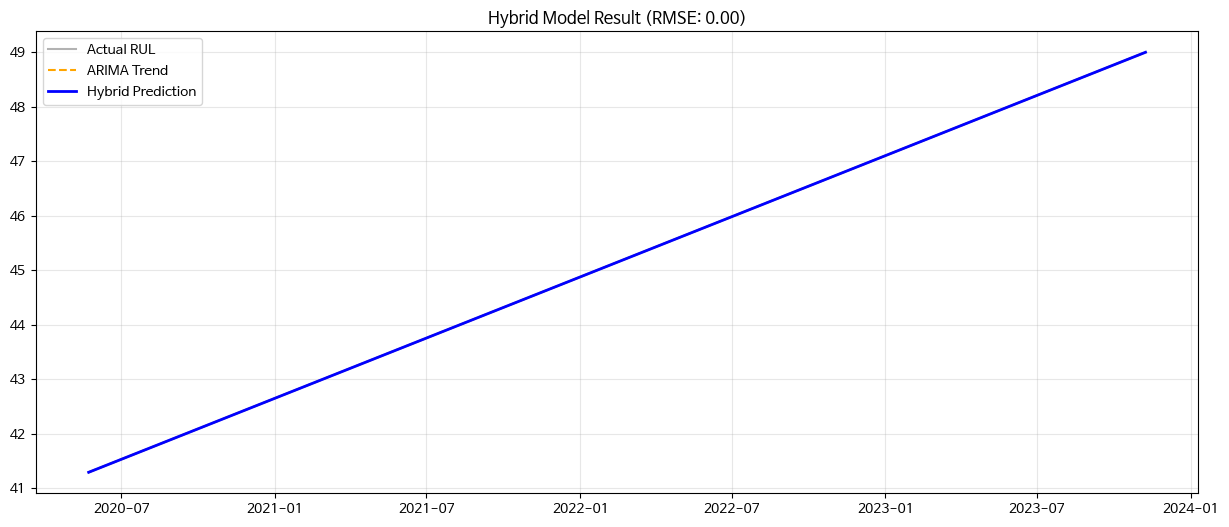

모든 결과 파일 저장 완료!
 - JSON: /content/drive/MyDrive/U-sto_AI/ai_model/saved_models/hybrid_arima_xgb/params.json
 - CSV : /content/drive/MyDrive/U-sto_AI/ai_model/results/performance_comparison.csv
 - Plot: /content/drive/MyDrive/U-sto_AI/ai_model/results/plots/hybrid_prediction_plot.png


In [ ]:
# 1. 성능 지표 계산
rmse = np.sqrt(mean_squared_error(test_final['y'], test_final['final_pred']))
mape = mean_absolute_percentage_error(test_final['y'], test_final['final_pred'])
rmse_arima = np.sqrt(mean_squared_error(test_final['y'], test_final['y_arima']))

print("="*50)
print(f"[Result] Hybrid Model vs ARIMA Baseline")
print(f"ARIMA RMSE : {rmse_arima:.4f}")
print(f"Hybrid RMSE: {rmse:.4f} (▼ {rmse_arima - rmse:.4f} 개선)")
print(f"Hybrid MAPE: {mape:.4f}")
print("="*50)

# 2. 결과 JSON 저장 (saved_models 폴더)
params = {
    "model": "Hybrid_ARIMA_XGB",
    "best_rmse": round(rmse, 4),
    "best_mape": round(mape, 4),
    "improvement_vs_arima": round(((rmse_arima - rmse)/rmse_arima)*100, 2),
    "features_used": features
}
json_path = os.path.join(MODEL_SAVE_DIR, 'params.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

# 3. 결과 CSV 저장 (results 폴더 - 전체 비교용)
csv_path = os.path.join(RESULT_DIR, 'performance_comparison.csv')
result_df = pd.DataFrame([{
    'Model': 'Hybrid (ARIMA+XGB)',
    'RMSE': rmse,
    'MAPE': mape,
    'Date': pd.Timestamp.now().strftime('%Y-%m-%d')
}])

if os.path.exists(csv_path):
    result_df.to_csv(csv_path, mode='a', header=False, index=False) # 이어쓰기
else:
    result_df.to_csv(csv_path, index=False) # 새로 만들기

# 4. 그래프 저장 (results/plots 폴더)
plt.figure(figsize=(15, 6))
plt.plot(test_final.index, test_final['y'], label='Actual RUL', color='black', alpha=0.3)
plt.plot(test_final.index, test_final['y_arima'], label='ARIMA Trend', linestyle='--', color='orange')
plt.plot(test_final.index, test_final['final_pred'], label='Hybrid Prediction', color='blue', linewidth=2)
plt.title(f'Hybrid Model Result (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)

plot_path = os.path.join(PLOT_DIR, 'hybrid_prediction_plot.png')
plt.savefig(plot_path)
plt.show()

print(f"모든 결과 파일 저장 완료!")
print(f" - JSON: {json_path}")
print(f" - CSV : {csv_path}")
print(f" - Plot: {plot_path}")